# Week 4: [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/overview)
### Decription
Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:
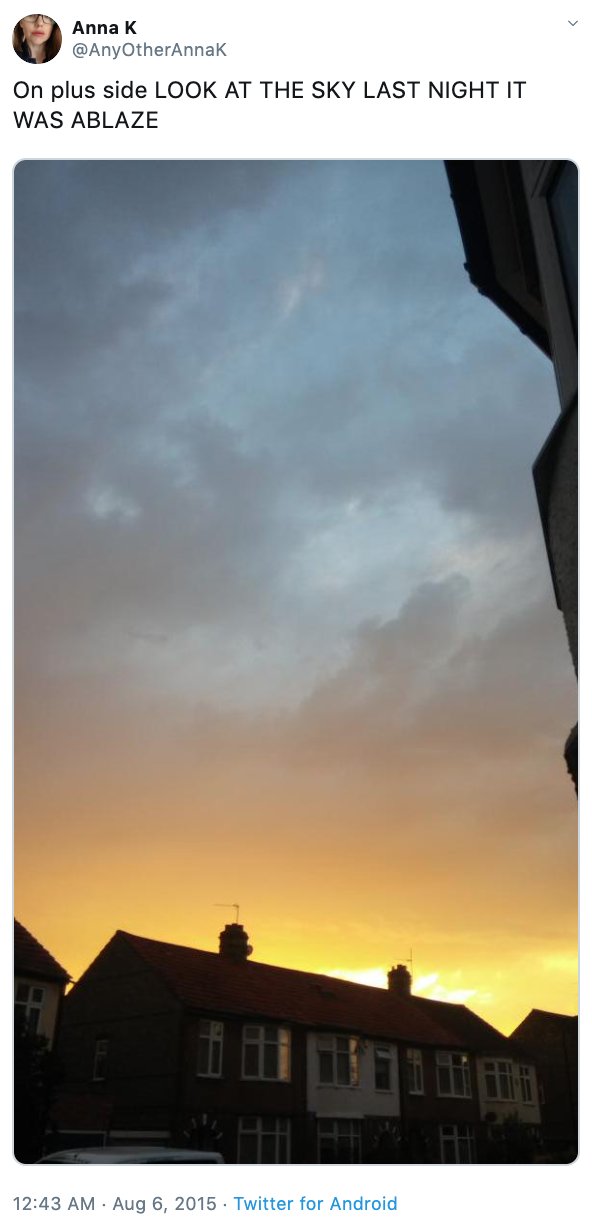

The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

### 1. Dataset Description
Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.

**What should I expect the data format to be?**

Each sample in the train and test set has the following information:

The `text` of a tweet
A `keyword` from that tweet (although this may be blank!)
The `location` the tweet was sent from (may also be blank)

**What am I predicting?**

You are predicting whether a given tweet is about a real disaster or not. If so, predict a `1`. If not, predict a `0`.

**Files**

* `data/train.csv` - the training set
* `data/test.csv` - the test set
* `data/sample_submission.csv` - a sample submission file in the correct format

**Columns**

* `id` - a unique identifier for each tweet
* `text` - the text of the tweet
* `location` - the location the tweet was sent from (may be blank)
* `keyword` - a particular keyword from the tweet (may be blank)
* `target` - in **train.csv** only, this denotes whether a tweet is about a real disaster (`1`) or not (`0`)

### 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data
Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import ssl

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Embedding, LSTM, GRU, Bidirectional, 
                                      Dropout, Conv1D, GlobalMaxPooling1D, 
                                      SpatialDropout1D, MaxPooling1D)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import nltk
from nltk.corpus import stopwords

2025-11-29 08:03:13.245595: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Setting style for consistent plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# Load data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [4]:
print(f"Train shape: {train_df.shape}")
train_df.info()
print(train_df.head())

Train shape: (7613, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [5]:
print(f"Test shape: {test_df.shape}")
test_df.info()
print(test_df.head())

Test shape: (3263, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
# Check for Null/missing values
train_missing = train_df.isnull().sum()
train_missing_pct = (train_missing / len(train_df)) * 100

test_missing = test_df.isnull().sum()
test_missing_pct = (test_missing / len(test_df)) * 100

missing_sum = pd.DataFrame({
    'Train_Missing': train_missing,
    'Train_Percentage': train_missing_pct,
    'Test_Missing': test_missing,
    'Test_Percentage': test_missing_pct
})

print(missing_sum)

          Train_Missing  Train_Percentage  Test_Missing  Test_Percentage
id                    0          0.000000           0.0         0.000000
keyword              61          0.801261          26.0         0.796813
location           2533         33.272035        1105.0        33.864542
target                0          0.000000           NaN              NaN
text                  0          0.000000           0.0         0.000000


Target Distribution:
Class 0 - Not Disaster: 4342 (57.03%)
Class 1 - Disaster: 3271 (42.97%)


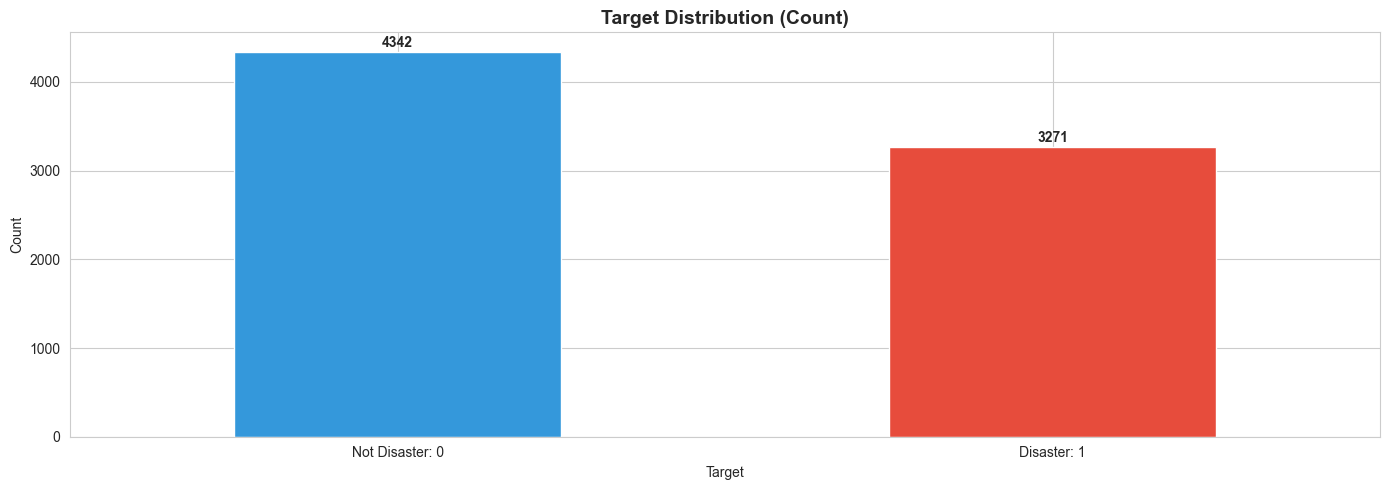

In [7]:
# Distribution
target_counts = train_df['target'].value_counts()
target_pct = train_df['target'].value_counts(normalize=True) * 100

print("Target Distribution:")
print(f"Class 0 - Not Disaster: {target_counts[0]} ({target_pct[0]:.2f}%)")
print(f"Class 1 - Disaster: {target_counts[1]} ({target_pct[1]:.2f}%)")

# Visualize target distribution
fig, ax = plt.subplots(1, 1, figsize=(14, 5))

# Plot
target_counts.plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c'])
ax.set_title('Target Distribution (Count)', fontsize=14, fontweight='bold')
ax.set_xlabel('Target')
ax.set_ylabel('Count')
ax.set_xticklabels(['Not Disaster: 0', 'Disaster: 1'], rotation=0)

# Add count labels on bars
for i, v in enumerate(target_counts):
    ax.text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

Text Length Stats by Class:
       text_length                                                          \
             count        mean        std   min   25%    50%    75%    max   
target                                                                       
0           4342.0   95.706817  35.885924   7.0  68.0  101.0  130.0  157.0   
1           3271.0  108.113421  29.309854  14.0  88.0  115.0  136.0  151.0   

       word_count                                                    
            count       mean       std  min   25%   50%   75%   max  
target                                                               
0          4342.0  14.704744  6.161564  1.0  10.0  15.0  19.0  31.0  
1          3271.0  15.167533  5.096806  2.0  11.0  15.0  19.0  30.0  


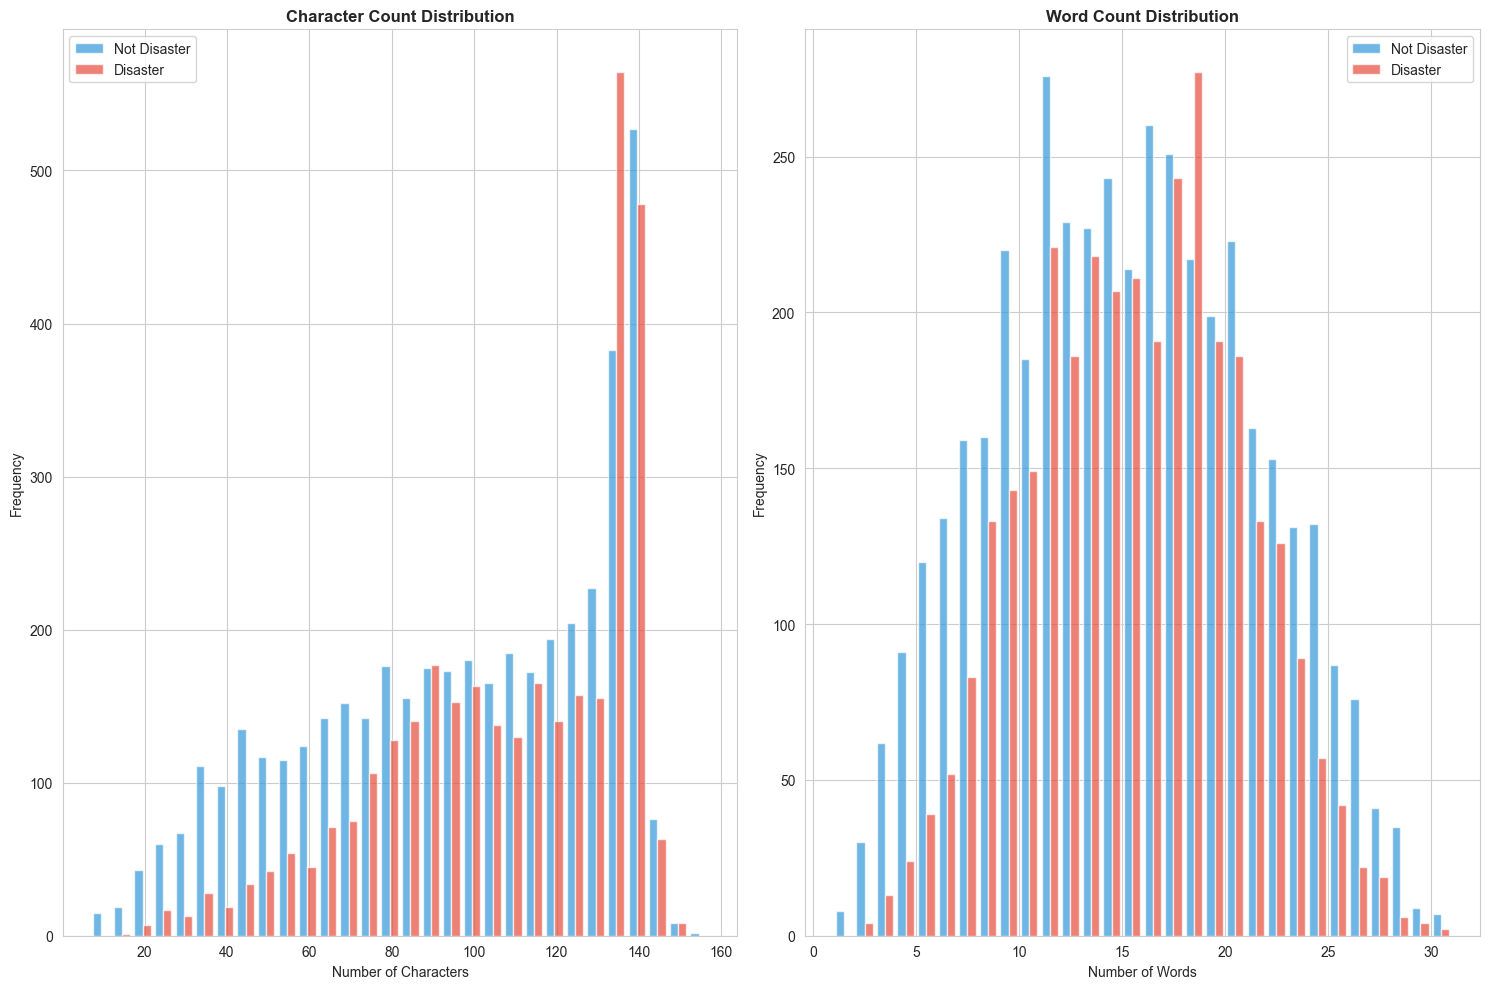

In [8]:
# Text Analysis

# Lengths
train_df['text_length'] = train_df['text'].astype(str).apply(len)
train_df['word_count'] = train_df['text'].astype(str).apply(lambda x: len(x.split()))

# Statistics by class
print("Text Length Stats by Class:")
length_stats = train_df.groupby('target')[['text_length', 'word_count']].describe()
print(length_stats)

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Character count
axes[0].hist([train_df[train_df['target']==0]['text_length'], 
                 train_df[train_df['target']==1]['text_length']], 
                bins=30, label=['Not Disaster', 'Disaster'], 
                color=['#3498db', '#e74c3c'], alpha=0.7)
axes[0].set_title('Character Count Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Characters')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Word count
axes[1].hist([train_df[train_df['target']==0]['word_count'], 
                 train_df[train_df['target']==1]['word_count']], 
                bins=30, label=['Not Disaster', 'Disaster'], 
                color=['#3498db', '#e74c3c'], alpha=0.7)
axes[1].set_title('Word Count Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

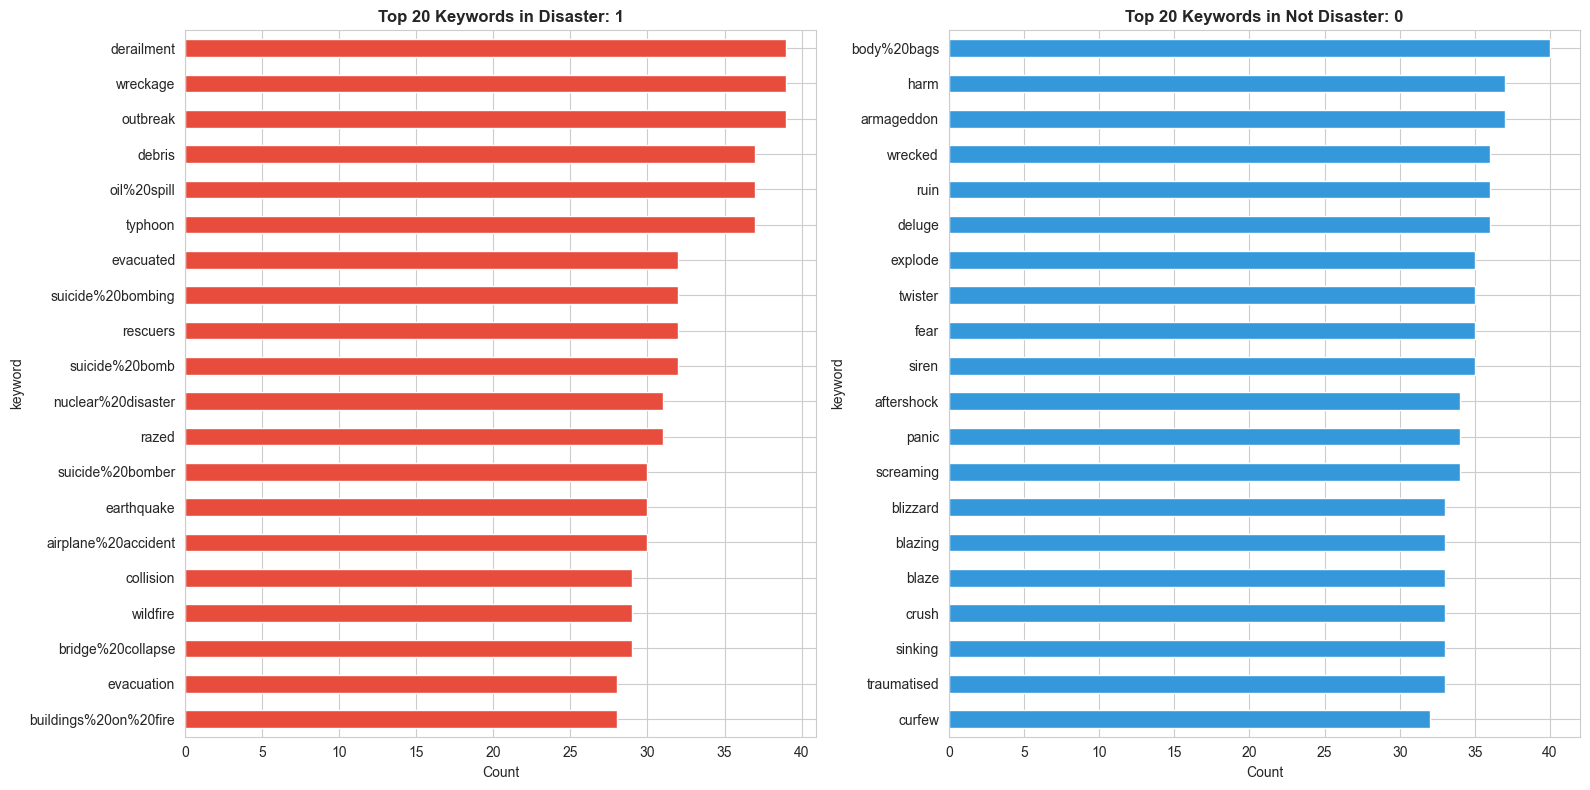

In [9]:
# Keyword Stats

# Top 20
disaster_keywords = train_df[train_df['target']==1]['keyword'].value_counts().head(20)
non_disaster_keywords = train_df[train_df['target']==0]['keyword'].value_counts().head(20)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Disaster
disaster_keywords.plot(kind='barh', ax=axes[0], color='#e74c3c')
axes[0].set_title('Top 20 Keywords in Disaster: 1', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Count')
axes[0].invert_yaxis()

# Non-disaster
non_disaster_keywords.plot(kind='barh', ax=axes[1], color='#3498db')
axes[1].set_title('Top 20 Keywords in Not Disaster: 0', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Count')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# %20 represents a space character. 

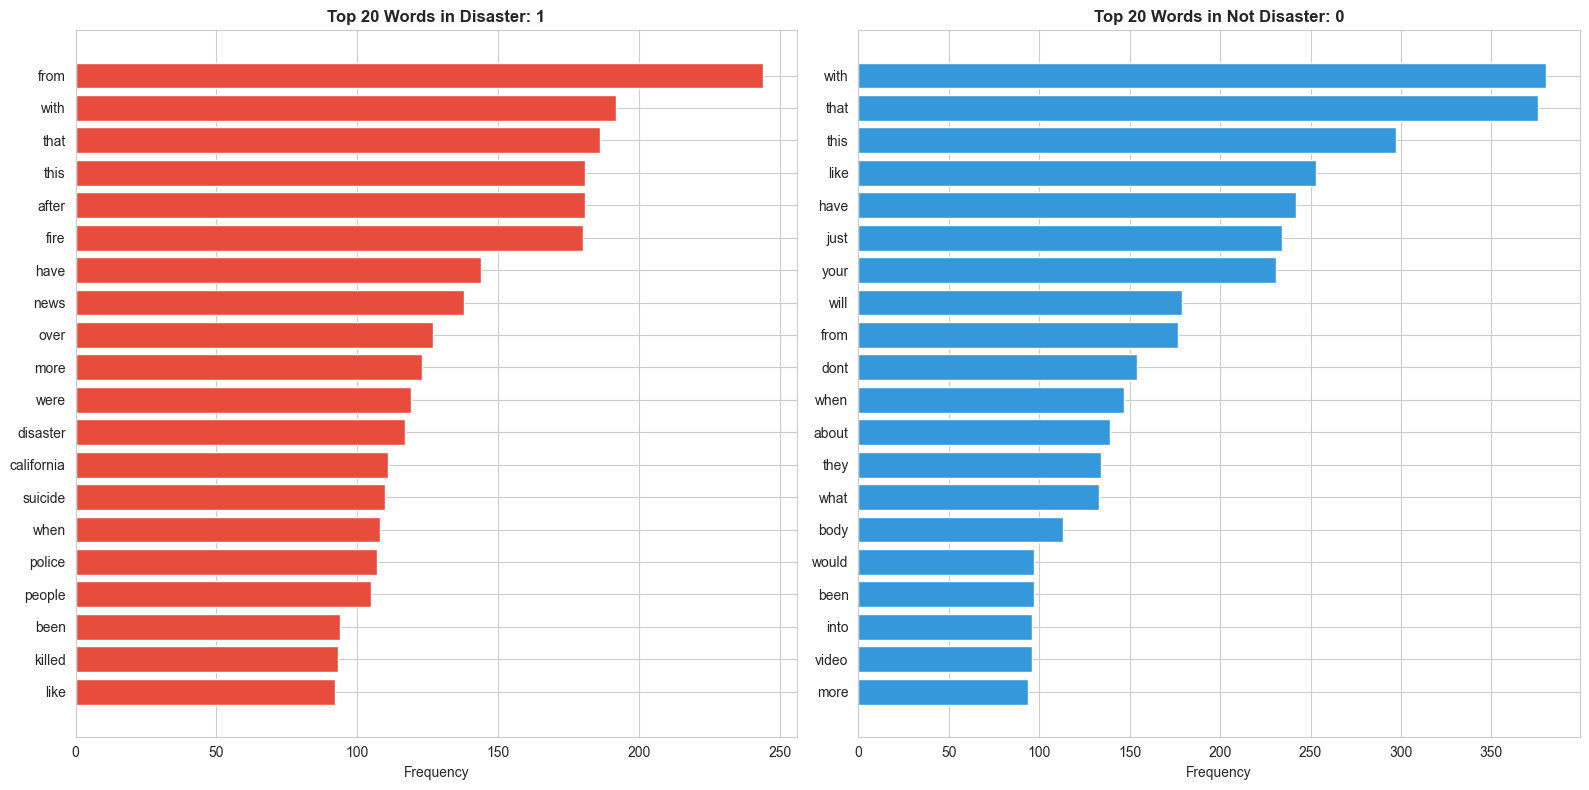

In [10]:
# Word Stats
# Get top words for each class
def get_top_words(texts, top_n=20, short_len=3):
    """Extract top n words from texts"""
    words = ' '.join(texts.astype(str)).lower().split()
    # Remove URLs, mentions, and special characters
    words = [re.sub(r'http\S+|www\S+|@\w+|[^a-z\s]', '', word) for word in words]
    words = [word for word in words if len(word) > short_len]  # Remove short words
    word_freq = Counter(words)
    return word_freq.most_common(top_n)

disaster_words = get_top_words(train_df[train_df['target']==1]['text'])
non_disaster_words = get_top_words(train_df[train_df['target']==0]['text'])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Disaster words
words_d, counts_d = zip(*disaster_words)
axes[0].barh(words_d, counts_d, color='#e74c3c')
axes[0].set_title('Top 20 Words in Disaster: 1', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Frequency')
axes[0].invert_yaxis()

# Not Disaster words
words_nd, counts_nd = zip(*non_disaster_words)
axes[1].barh(words_nd, counts_nd, color='#3498db')
axes[1].set_title('Top 20 Words in Not Disaster: 0', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Frequency')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

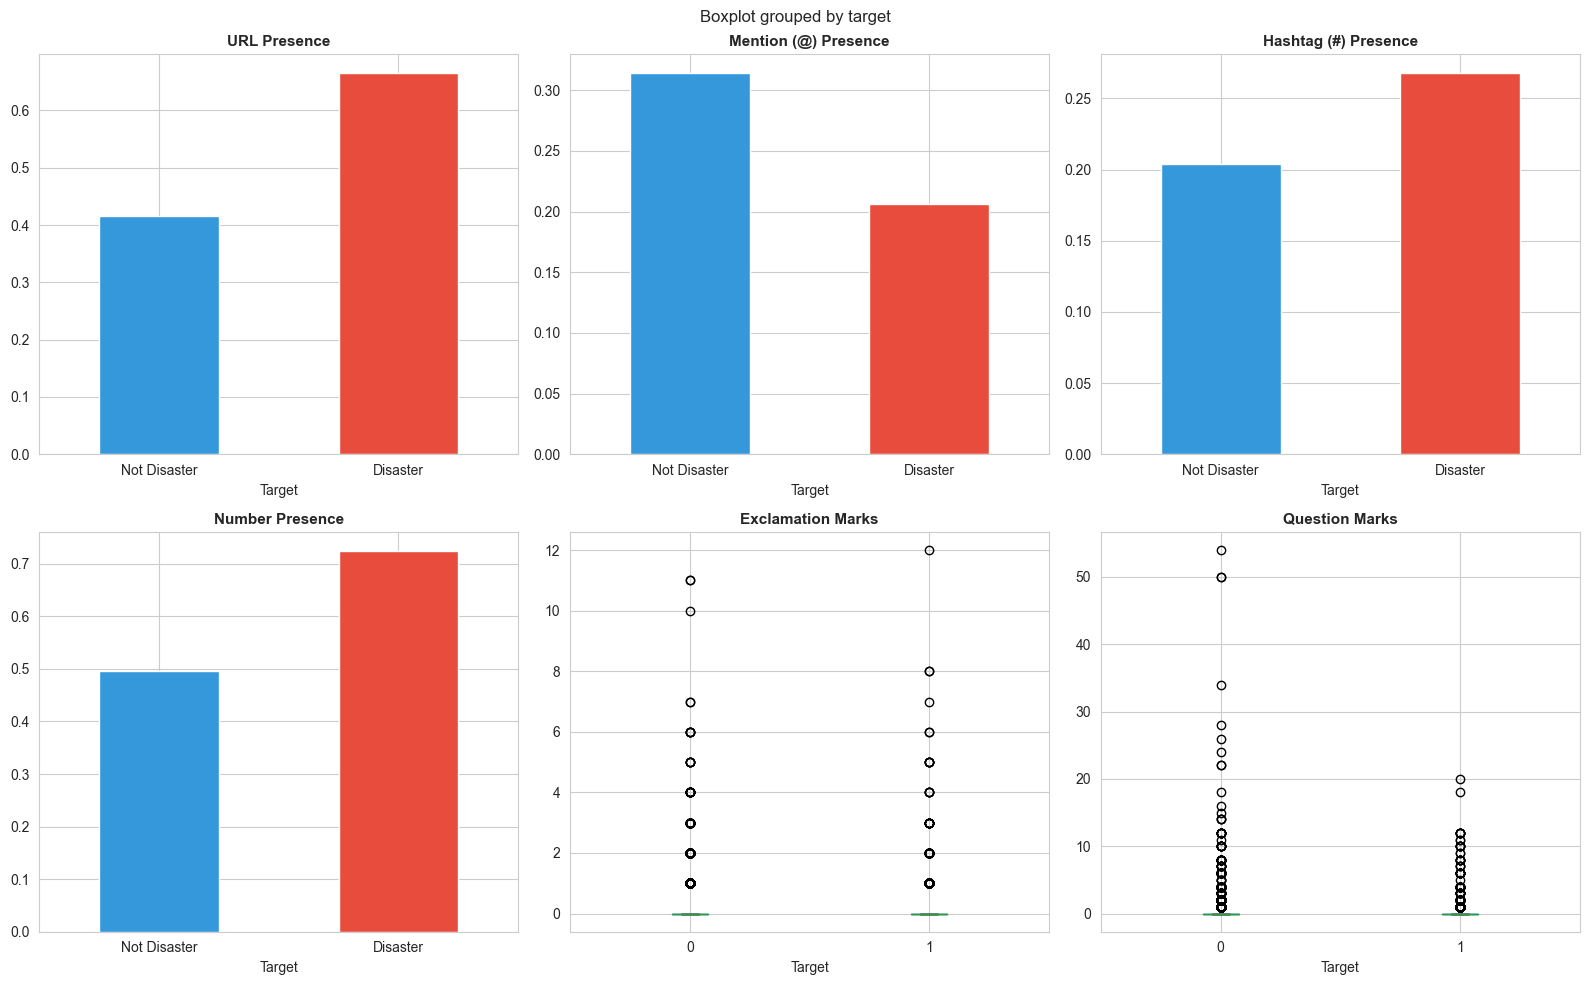

In [11]:
# Special Character Stats
train_df['has_url'] = train_df['text'].apply(lambda x: 1 if re.search(r'http\S+|www\S+', str(x)) else 0)
train_df['has_mention'] = train_df['text'].apply(lambda x: 1 if '@' in str(x) else 0)
train_df['has_hashtag'] = train_df['text'].apply(lambda x: 1 if '#' in str(x) else 0)
train_df['has_number'] = train_df['text'].apply(lambda x: 1 if any(char.isdigit() for char in str(x)) else 0)
train_df['exclamation_count'] = train_df['text'].apply(lambda x: str(x).count('!'))
train_df['question_count'] = train_df['text'].apply(lambda x: str(x).count('?'))


# Visualize
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
features = ['has_url', 'has_mention', 'has_hashtag', 'has_number', 
            'exclamation_count', 'question_count']
titles = ['URL Presence', 'Mention (@) Presence', 'Hashtag (#) Presence', 
          'Number Presence', 'Exclamation Marks', 'Question Marks']

for idx, (feature, title) in enumerate(zip(features, titles)):
    row = idx // 3
    col = idx % 3
    
    if feature in ['exclamation_count', 'question_count']:
        train_df.boxplot(column=feature, by='target', ax=axes[row, col])
    else:
        train_df.groupby('target')[feature].mean().plot(kind='bar', ax=axes[row, col], 
                                                         color=['#3498db', '#e74c3c'])
    
    axes[row, col].set_title(title, fontsize=11, fontweight='bold')
    axes[row, col].set_xlabel('Target')
    if feature not in ['exclamation_count', 'question_count']:
        axes[row, col].set_xticklabels(['Not Disaster', 'Disaster'], rotation=0)

plt.tight_layout()
plt.show()

### 3. Model Architecture
Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.  

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.). 

In [12]:
# Workaround for importing stopwords
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
    
# Download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/drivera53/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
print(f"TensorFlow version: {tf.__version__}")
print(f"GPUs: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.16.2
GPUs: []


In [14]:
# Helper function for cleaning and normalizing text
def clean_text(text):
    text = str(text) # Convert to string
    text = text.lower() # Lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
    text = re.sub(r'@\w+', '', text) # Remove mentions
    text = re.sub(r'#', '', text) # Remove hashtag symbol but keep text
    text = re.sub(r'[^a-zA-Z\s!?.]', '', text) # Remove special characters and numbers (keep letters and basic punctuation)
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    
    return text

train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

# Check some samples
for i in range(3):
    print(f"Original: {train_df['text'].iloc[i]}")
    print(f"Cleaned:  {train_df['clean_text'].iloc[i]}")

Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Cleaned:  our deeds are the reason of this earthquake may allah forgive us all
Original: Forest fire near La Ronge Sask. Canada
Cleaned:  forest fire near la ronge sask. canada
Original: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
Cleaned:  all residents asked to shelter in place are being notified by officers. no other evacuation or shelter in place orders are expected


In [15]:
# Tokenization Configuration
MAX_WORDS = 15000  # Maximum vocabulary size
MAX_LEN = 100      # Maximum sequence length
EMBEDDING_DIM = 100  # Embedding dimension

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')

# Fit
tokenizer.fit_on_texts(train_df['clean_text'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

print(f"Unique words: {vocab_size}")
print(f"Words to use: {min(MAX_WORDS, vocab_size)}")
print("Top 10 Most Common Words:")
sorted_words = sorted(word_index.items(), key=lambda x: x[1])[:10]
for word, idx in sorted_words:
    print(f"  {idx:3d}: {word}")

Unique words: 14589
Words to use: 14589
Top 10 Most Common Words:
    1: <OOV>
    2: the
    3: a
    4: in
    5: to
    6: of
    7: i
    8: and
    9: is
   10: for


In [16]:
# Text to Sequences
X_train_seq = tokenizer.texts_to_sequences(train_df['clean_text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['clean_text'])

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"X_train: {X_train_padded.shape}")
print(f"X_test:  {X_test_padded.shape}")
# Sample
idx = 10
print(f"Original text: {train_df['text'].iloc[idx]}")
print(f"Cleaned text:  {train_df['clean_text'].iloc[idx]}")
print(f"Sequence:      {X_train_seq[idx]}")
print(f"Padded:        {X_train_padded[idx]}")

X_train: (7613, 100)
X_test:  (3263, 100)
Original text: Three people died from the heat wave so far
Cleaned text:  three people died from the heat wave so far
Sequence:      [588, 58, 614, 20, 2, 257, 442, 31, 615]
Padded:        [588  58 614  20   2 257 442  31 615   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [17]:
# Train-Validation Split

# Labels
y = train_df['target'].values

# Split data:
# 80 train
# 20 validation
TEST_SPLIT = 0.2
X_train, X_val, y_train, y_val = train_test_split(
    X_train_padded, y, 
    test_size=TEST_SPLIT, 
    random_state=42, 
    stratify=y
)

print(f"Training samples:   {X_train.shape[0]} ({y_train.sum()} disaster)")
print(f"Validation samples: {X_val.shape[0]} ({y_val.sum()} disaster)")
print(f"Test samples:       {X_test_padded.shape[0]}")

# Weights
class_weights = {
    0: len(y_train) / (2 * (y_train == 0).sum()),
    1: len(y_train) / (2 * (y_train == 1).sum())
}

print(f"Class 0 - Not Disaster: {class_weights[0]}")
print(f"Class 1 - Disaster:     {class_weights[1]}")

Training samples:   6090 (2617 disaster)
Validation samples: 1523 (654 disaster)
Test samples:       3263
Class 0 - Not Disaster: 0.8767636049524906
Class 1 - Disaster:     1.1635460450897974


In [18]:
# Model 1: Simple Long Short-Term Memory
# Helper function
def create_lstm_model(vocab_size, embedding_dim):
    model = Sequential([
        Embedding(vocab_size, embedding_dim),                       # Converts word indices to dense vectors
        LSTM(64, return_sequences=False),                           # Remembers important information from earlier in sequence, 128 hidden units 
        Dropout(0.3),
        # Dense(64, activation='relu'),                               # Standard fully connected layers, 64 units with ReLU activation
        Dropout(0.2),                                               # Regularization to prevent overfitting, drops 30% of connections during training
        Dense(1, activation='sigmoid')
    ])
    return model

# Create model
lstm_model = create_lstm_model(min(MAX_WORDS, vocab_size), EMBEDDING_DIM)

# Compile with higher learning rate
lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Default is 0.001
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), 
             tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

# lstm_model.summary()

In [19]:
# Model 2: Bidirectional Long Short-Term Memory

# Why Bidirectional? Bidirectional sees both contexts
# Example: "The bank is on the river" vs "I went to the bank"
# Forward pass: "the bank..." -> Financial institution?
# Backward pass: "...river bank" -> riverbank!

# Helper function
def create_bilstm_model(vocab_size, embedding_dim):
    model = Sequential([
        Embedding(vocab_size, embedding_dim), # Same as LSTM
        Bidirectional(LSTM(128, return_sequences=False)),           # Processes text in both directions (forward and backward), 128 units per direction
        Dropout(0.3),
        Dense(64, activation='relu'),                               # Same as LSTM
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

# Create model
bilstm_model = create_bilstm_model(min(MAX_WORDS, vocab_size), EMBEDDING_DIM)

# Compile model
bilstm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), 
             tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

# bilstm_model.summary()

In [20]:
# Model 3: Gated Recurrent Unit

# GRU vs LSTM:
# GRU: Simpler, fewer parameters, faster
# LSTM: More complex, more parameters, slightly more powerful
# For short texts (tweets), GRU often sufficient

# Helper function
def create_gru_model(vocab_size, embedding_dim):
    model = Sequential([
        Embedding(vocab_size, embedding_dim),                        # Same as LSTM
        GRU(128, return_sequences=False),                            # Simpler than LSTM, fewer parameters
        Dropout(0.3),
        Dense(64, activation='relu'),                                # Same as LSTM
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

# Create model
gru_model = create_gru_model(min(MAX_WORDS, vocab_size), EMBEDDING_DIM)

# Compile model
gru_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), 
             tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

# gru_model.summary()

In [21]:
# Model 4: CNN for Text Classification

# Why CNN? Good at detecting key phrases and patterns
# Example: "on fire", "caught fire", "set ablaze"
# CNN filters learn these disaster-related phrases
# Faster than RNNs, good for shorter texts

# Helper function
def create_cnn_model(vocab_size, embedding_dim, lstm_units=128, droput_rate=0.5):
    model = Sequential([
        Embedding(vocab_size, embedding_dim),  # Same as LSTM
        SpatialDropout1D(0.2),                                       # Dropout entire feature maps (better for embeddings), prevents co-adaptation of features
        Conv1D(lstm_units, 5, activation='relu'),                    # Applies filters to capture n-gram patterns, finds local patterns (phrases) in text 
        GlobalMaxPooling1D(),                                        # Takes maximum value from each filter, captures most important features
        Dense(64, activation='relu'),                                # Same as LSTM
        Dropout(droput_rate),
        Dense(1, activation='sigmoid')
    ])
    return model

# Create model
cnn_model = create_cnn_model(min(MAX_WORDS, vocab_size), EMBEDDING_DIM)

# Compile model
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), 
             tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

# cnn_model.summary()

In [22]:
# Model 5: Hybrid LSTM + CNN

# Why Hybrid? Combines strengths of both models
# CNN: Captures local patterns (key phrases)
# LSTM: Understands sequence and context
# Example: CNN finds "fire", LSTM understands if it's literal or figurative

# Helper function
def create_hybrid_model(vocab_size, embedding_dim):
    model = Sequential([
        Embedding(vocab_size, embedding_dim),                        # Same as LSTM
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(pool_size=2),                                   # Conv1D + MaxPooling: First extracts local features (phrases) 
        LSTM(64, return_sequences=True),                             # Captures sequential dependencies and passed output to next LSTM
        LSTM(32),                                                    # Further processes sequential information
        Dense(64, activation='relu'),                                # Same as LSTM
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

# Create model
hybrid_model = create_hybrid_model(min(MAX_WORDS, vocab_size), EMBEDDING_DIM)

# Compile model
hybrid_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), 
             tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

# hybrid_model.summary()

In [23]:
# Training Configuration

# Parameters
BATCH_SIZE = 32
EPOCHS = 20 # Add more if needed, might need a more powerful PC :(

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',         # Stops training if validation loss doesn't improve
        patience=5,                 # Wait 3 epochs before stopping
        restore_best_weights=True,  # Restores best weights from training
        verbose=1                   # Prevents overfitting
    ),
    ReduceLROnPlateau(
        monitor='val_loss',         # Reduces learning rate when loss plateaus
        factor=0.5,                 # Reduce LR by half 
        patience=3,                 # Wait 2 epochs before reducing
        min_lr=1e-7,
        verbose=1                   # Helps fine-tune the model    
    )
]

In [24]:
# Training Helper Functions
def find_optimal_threshold(model, X_val, y_val):
    """Find optimal classification threshold"""
    y_pred_prob = model.predict(X_val, verbose=0).flatten()
    
    best_threshold = 0.5
    best_f1 = 0
    
    for threshold in np.arange(0.3, 0.7, 0.05):
        y_pred = (y_pred_prob > threshold).astype(int)
        # Zero_division parameter here
        f1 = f1_score(y_val, y_pred, zero_division=0)
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    print(f"Optimal threshold: {best_threshold:.2f} (F1: {best_f1:.4f})")
    return best_threshold
    
def train_and_evaluate(model, model_name, X_train, y_train, X_val, y_val):
    """
    Train model and return history
    """
    print(f"Training: {model_name}")
    history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )
    
    val_loss, val_acc, val_prec, val_rec, val_auc = model.evaluate(X_val, y_val, verbose=0)
    val_f1 = 2 * (val_prec * val_rec) / (val_prec + val_rec + 1e-7)
    
    print(f"  Loss:      {val_loss:.4f}")
    print(f"  Accuracy:  {val_acc:.4f}")
    print(f"  Precision: {val_prec:.4f}")
    print(f"  Recall:    {val_rec:.4f}")
    print(f"  F1-Score:  {val_f1:.4f}")
    print(f"  AUC:       {val_auc:.4f}")
    
    # Find optimal threshold (with suppressed warnings)
    optimal_threshold = find_optimal_threshold(model, X_val, y_val)
    
    # Use optimal threshold for predictions
    y_pred_prob = model.predict(X_val, verbose=0).flatten()
    y_pred = (y_pred_prob > optimal_threshold).astype(int)
    
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    print(cm)
    
    # Classification Report with zero_division parameter
    print(classification_report(y_val, y_pred, 
                                target_names=['Not Disaster', 'Disaster'],
                                zero_division=0))
    
    return history, model

### 4. Results and Analysis
Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

In [25]:
# Train All Models and Store Results
results = {}
histories = {}

In [26]:
# Train Model 1: Simple Long Short-Term Memory
history_lstm, trained_lstm = train_and_evaluate(
    lstm_model, "Simple LSTM", X_train, y_train, X_val, y_val
)
results['Simple LSTM'] = {
    'model': trained_lstm,
    'history': history_lstm
}
histories['Simple LSTM'] = history_lstm

Training: Simple LSTM
Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.5049 - auc: 0.4974 - loss: 0.6944 - precision: 0.4242 - recall: 0.4257 - val_accuracy: 0.5706 - val_auc: 0.5000 - val_loss: 0.6914 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.5030 - auc: 0.4973 - loss: 0.6939 - precision: 0.4324 - recall: 0.5010 - val_accuracy: 0.5706 - val_auc: 0.5000 - val_loss: 0.6880 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.5048 - auc: 0.5007 - loss: 0.6939 - precision: 0.4336 - recall: 0.4975 - val_accuracy: 0.4294 - val_auc: 0.5000 - val_loss: 0.6986 - val_precision: 0.4294 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.4882 - auc: 0.4994 - loss: 0.6939 - precision: 0.4256 - recall: 0.5468 - val_accuracy: 0.5706 

In [27]:
# Train Model 2: Bidirectional Long Short-Term Memory
history_bilstm, trained_bilstm = train_and_evaluate(
    bilstm_model, "Bidirectional LSTM", X_train, y_train, X_val, y_val
)
results['Bidirectional LSTM'] = {
    'model': trained_bilstm,
    'history': history_bilstm
}
histories['Bidirectional LSTM'] = history_bilstm

Training: Bidirectional LSTM
Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.7140 - auc_1: 0.7885 - loss: 0.5490 - precision_1: 0.6545 - recall_1: 0.7081 - val_accuracy: 0.7879 - val_auc_1: 0.8531 - val_loss: 0.4743 - val_precision_1: 0.7550 - val_recall_1: 0.7492 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.8693 - auc_1: 0.9306 - loss: 0.3266 - precision_1: 0.8589 - recall_1: 0.8326 - val_accuracy: 0.7768 - val_auc_1: 0.8471 - val_loss: 0.4919 - val_precision_1: 0.7329 - val_recall_1: 0.7554 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.9294 - auc_1: 0.9748 - loss: 0.1972 - precision_1: 0.9220 - recall_1: 0.9129 - val_accuracy: 0.7420 - val_auc_1: 0.8409 - val_loss: 0.6169 - val_precision_1: 0.6650 - val_recall_1: 0.8043 - learning_rate: 0.0010
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9564 - auc_1: 0.9905 - loss: 0.1214 - precision_1: 0.9487 - reca

In [28]:
# Train Model 3: Gated Recurrent Unit
history_gru, trained_gru = train_and_evaluate(
    gru_model, "GRU", X_train, y_train, X_val, y_val
)
results['GRU'] = {
    'model': trained_gru,
    'history': history_gru
}
histories['GRU'] = history_gru

Training: GRU
Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.4929 - auc_2: 0.4886 - loss: 0.6945 - precision_2: 0.4153 - recall_2: 0.4410 - val_accuracy: 0.5706 - val_auc_2: 0.5000 - val_loss: 0.6888 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.5067 - auc_2: 0.4940 - loss: 0.6939 - precision_2: 0.4272 - recall_2: 0.4341 - val_accuracy: 0.4294 - val_auc_2: 0.5000 - val_loss: 0.6975 - val_precision_2: 0.4294 - val_recall_2: 1.0000 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4538 - auc_2: 0.4845 - loss: 0.6951 - precision_2: 0.4361 - recall_2: 0.8552
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.4841 - auc_2: 0.4963 - loss: 0.6935 - precision_2: 0.4309 - recall_2: 0.6255 - val_accuracy: 0.4294 - val_auc_2: 0.5000 - val_loss: 0.6933 - 

In [29]:
# Train Model 4: CNN for Text Classification
history_cnn, trained_cnn = train_and_evaluate(
    cnn_model, "CNN", X_train, y_train, X_val, y_val
)
results['CNN'] = {
    'model': trained_cnn,
    'history': history_cnn
}
histories['CNN'] = history_cnn

Training: CNN
Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6734 - auc_3: 0.7356 - loss: 0.6052 - precision_3: 0.6250 - recall_3: 0.5999 - val_accuracy: 0.7925 - val_auc_3: 0.8540 - val_loss: 0.4631 - val_precision_3: 0.7752 - val_recall_3: 0.7278 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8560 - auc_3: 0.9122 - loss: 0.3718 - precision_3: 0.8401 - recall_3: 0.8212 - val_accuracy: 0.7925 - val_auc_3: 0.8636 - val_loss: 0.4514 - val_precision_3: 0.7500 - val_recall_3: 0.7752 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9282 - auc_3: 0.9701 - loss: 0.2119 - precision_3: 0.9231 - recall_3: 0.9087 - val_accuracy: 0.7971 - val_auc_3: 0.8536 - val_loss: 0.5216 - val_precision_3: 0.7929 - val_recall_3: 0.7141 - learning_rate: 0.0010
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9611 - auc_3: 0.9878 - loss: 0.1285 - precision_3: 0.9566 - recall_3: 0.9526 - val

In [30]:
# Train Model 5: Hybrid LSTM + CNN
history_hybrid, trained_hybrid = train_and_evaluate(
    hybrid_model, "Hybrid CNN+LSTM", X_train, y_train, X_val, y_val
)
results['Hybrid CNN+LSTM'] = {
    'model': trained_hybrid,
    'history': history_hybrid
}
histories['Hybrid CNN+LSTM'] = history_hybrid

Training: Hybrid CNN+LSTM
Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5057 - auc_4: 0.4997 - loss: 0.6941 - precision_4: 0.4355 - recall_4: 0.5071 - val_accuracy: 0.4294 - val_auc_4: 0.5000 - val_loss: 0.7017 - val_precision_4: 0.4294 - val_recall_4: 1.0000 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.5177 - auc_4: 0.5008 - loss: 0.6937 - precision_4: 0.4366 - recall_4: 0.4207 - val_accuracy: 0.4294 - val_auc_4: 0.5000 - val_loss: 0.6952 - val_precision_4: 0.4294 - val_recall_4: 1.0000 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4825 - auc_4: 0.5134 - loss: 0.6954 - precision_4: 0.4429 - recall_4: 0.7106
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.4892 - auc_4: 0.4994 - loss: 0.6936 - precision_4: 0.4260 - recall_4: 0.5438 - val_accuracy: 0.5706 - val_auc_4: 0.5000 - val_loss: 0.6927 

In [31]:
# Compare Model Performance
performance_data = []

for model_name, model_data in results.items():
    model = model_data['model']
    
    # Evaluate on validation set
    val_loss, val_acc, val_prec, val_rec, val_auc = model.evaluate(X_val, y_val, verbose=0)
    val_f1 = 2 * (val_prec * val_rec) / (val_prec + val_rec + 1e-7)
    
    performance_data.append({
        'Model': model_name,
        'Loss': val_loss,
        'Accuracy': val_acc,
        'Precision': val_prec,
        'Recall': val_rec,
        'F1-Score': val_f1,
        'AUC': val_auc
    })

# Create performance dataframe
performance_df = pd.DataFrame(performance_data)
performance_df = performance_df.sort_values('F1-Score', ascending=False)
# Best model
print(performance_df.to_string(index=False))

             Model     Loss  Accuracy  Precision   Recall  F1-Score      AUC
               CNN 0.451435  0.792515   0.750000 0.775229  0.762406 0.863628
Bidirectional LSTM 0.474319  0.787919   0.755008 0.749235  0.752110 0.853130
   Hybrid CNN+LSTM 0.701666  0.429416   0.429416 1.000000  0.600827 0.500000
       Simple LSTM 0.687962  0.570584   0.000000 0.000000  0.000000 0.500000
               GRU 0.688763  0.570584   0.000000 0.000000  0.000000 0.500000


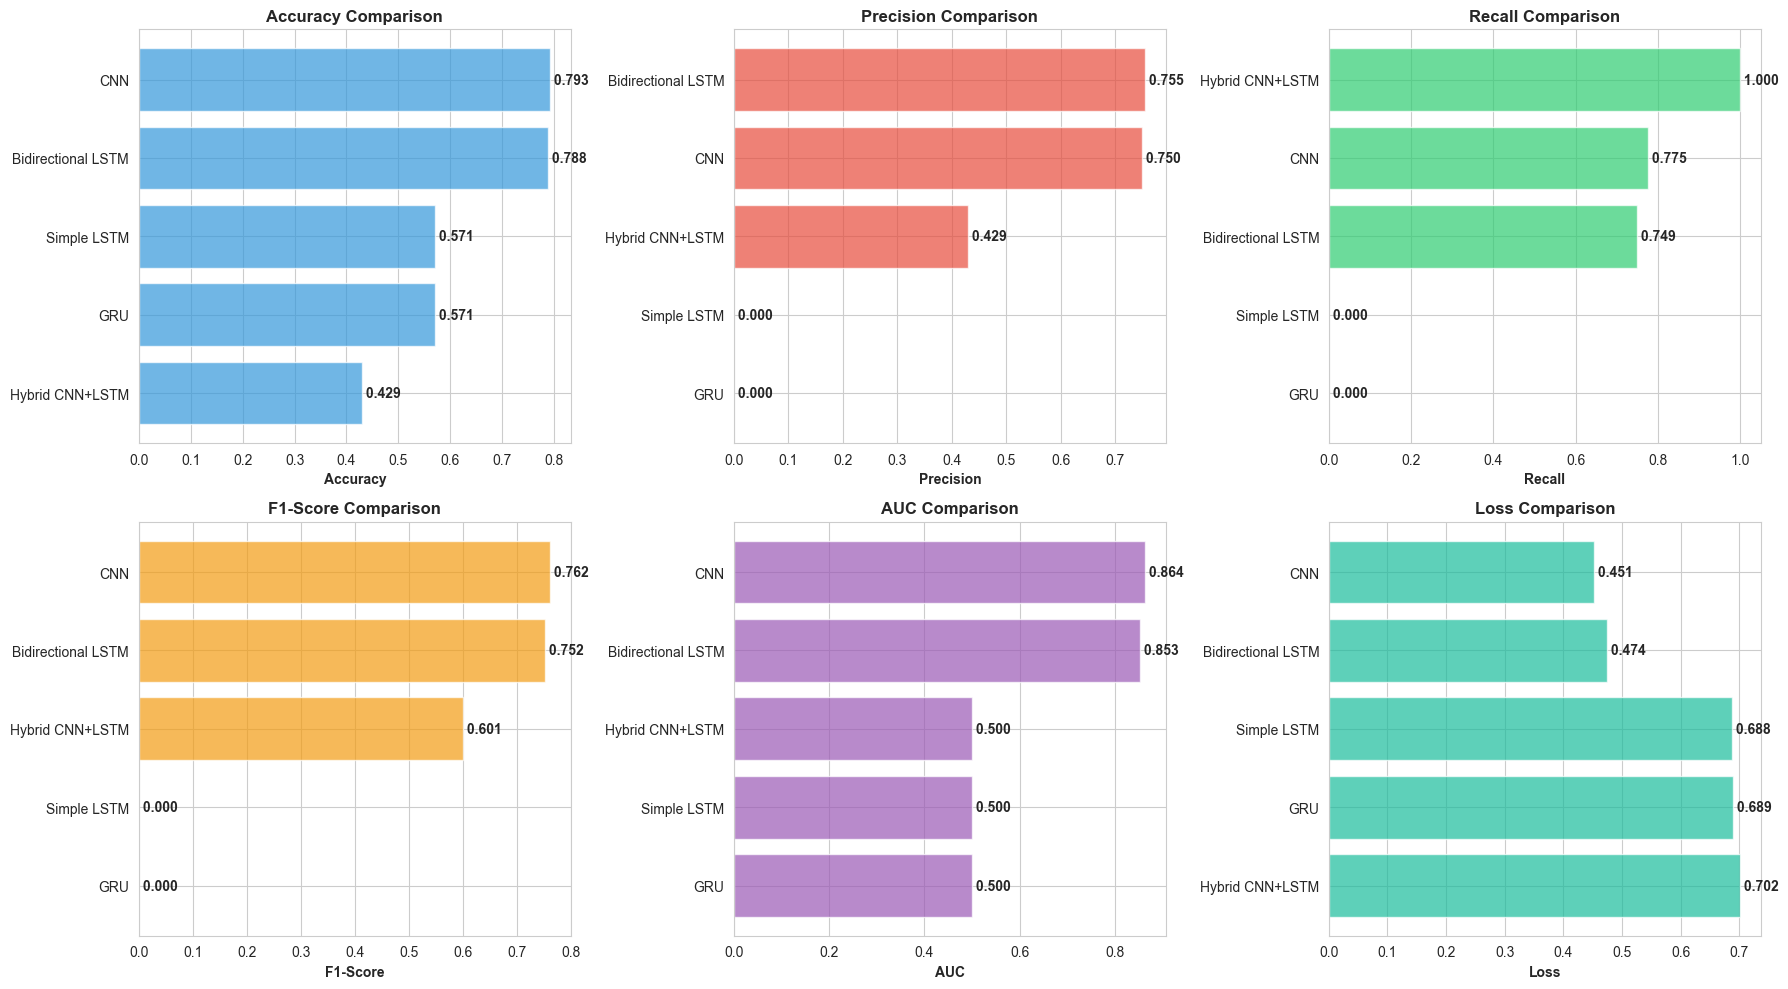

In [32]:
# Plot Model Performance Comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC', 'Loss']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    row = idx // 3
    col = idx % 3
    
    data = performance_df.sort_values(metric, ascending=(metric=='Loss'))
    
    axes[row, col].barh(data['Model'], data[metric], color=color, alpha=0.7)
    axes[row, col].set_xlabel(metric, fontweight='bold')
    axes[row, col].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    axes[row, col].invert_yaxis()
    
    # Add value labels
    for i, v in enumerate(data[metric]):
        axes[row, col].text(v, i, f' {v:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

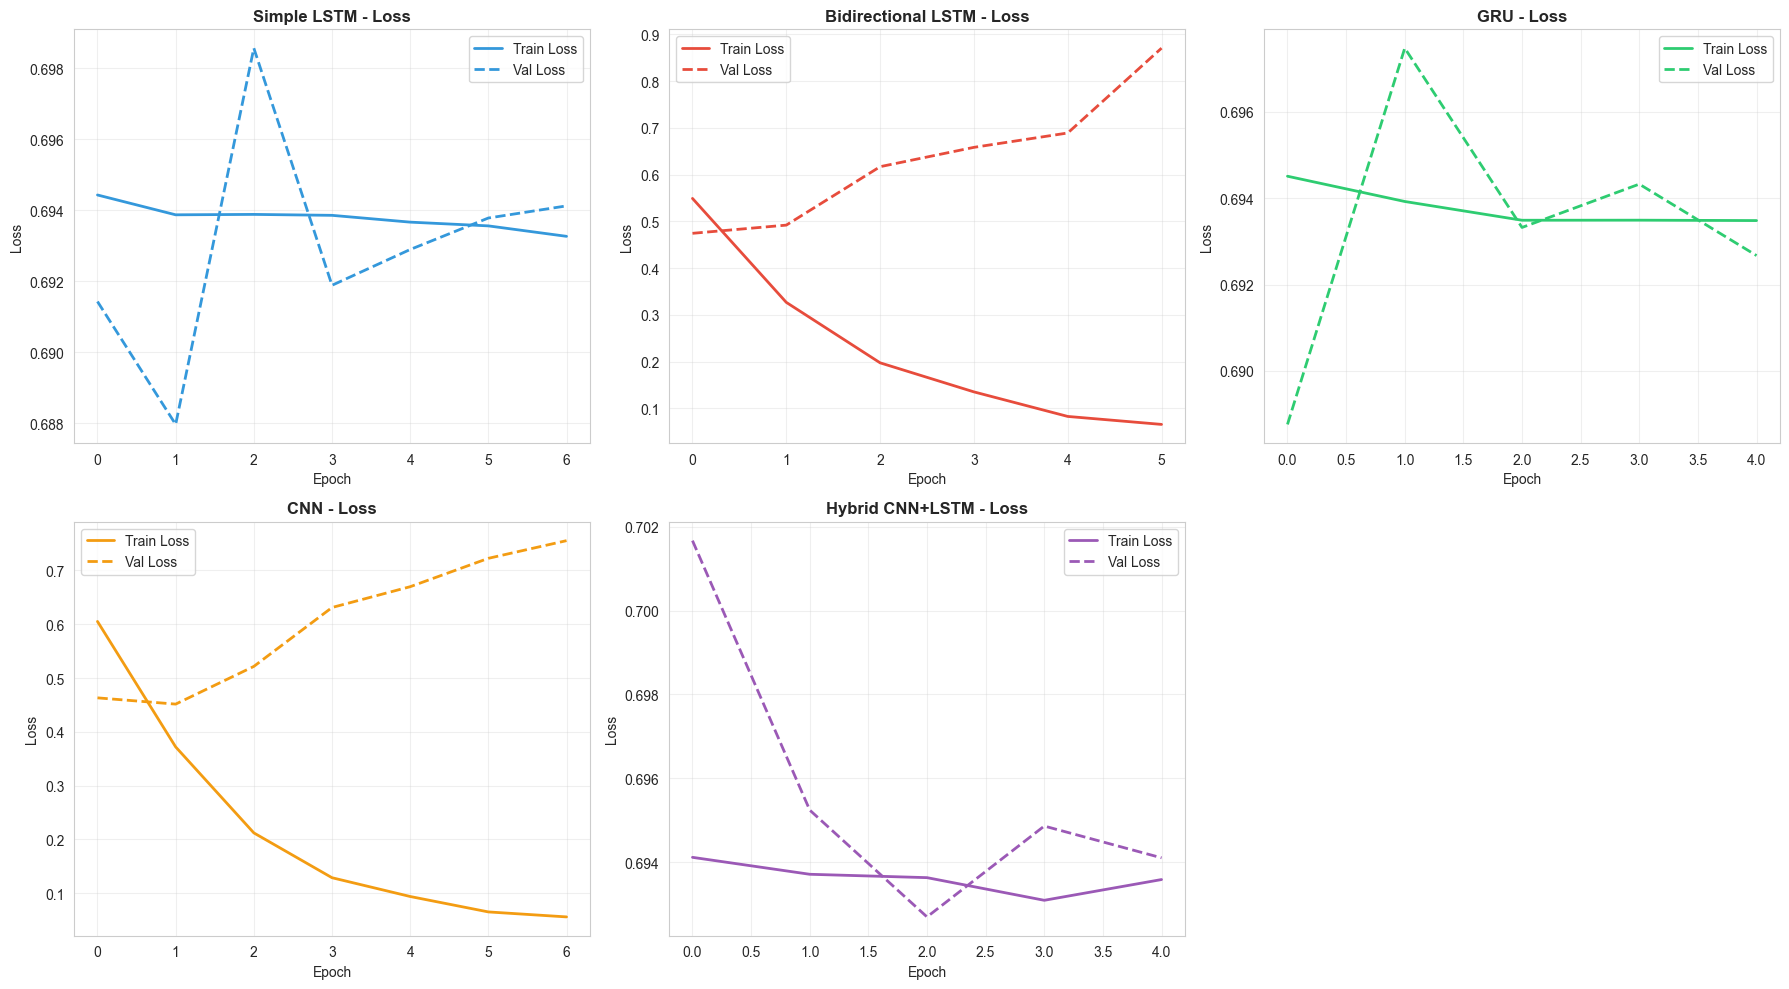

In [33]:
# Plot Training History (Learning Curves)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

model_names = list(histories.keys())
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

for idx, (model_name, color) in enumerate(zip(model_names, colors)):
    row = idx // 3
    col = idx % 3
    
    history = histories[model_name]
    
    # Plot loss
    axes[row, col].plot(history.history['loss'], label='Train Loss', 
                        color=color, linewidth=2)
    axes[row, col].plot(history.history['val_loss'], label='Val Loss', 
                        color=color, linestyle='--', linewidth=2)
    axes[row, col].set_title(f'{model_name} - Loss', fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('Epoch')
    axes[row, col].set_ylabel('Loss')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

if len(model_names) % 3 != 0:
    fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

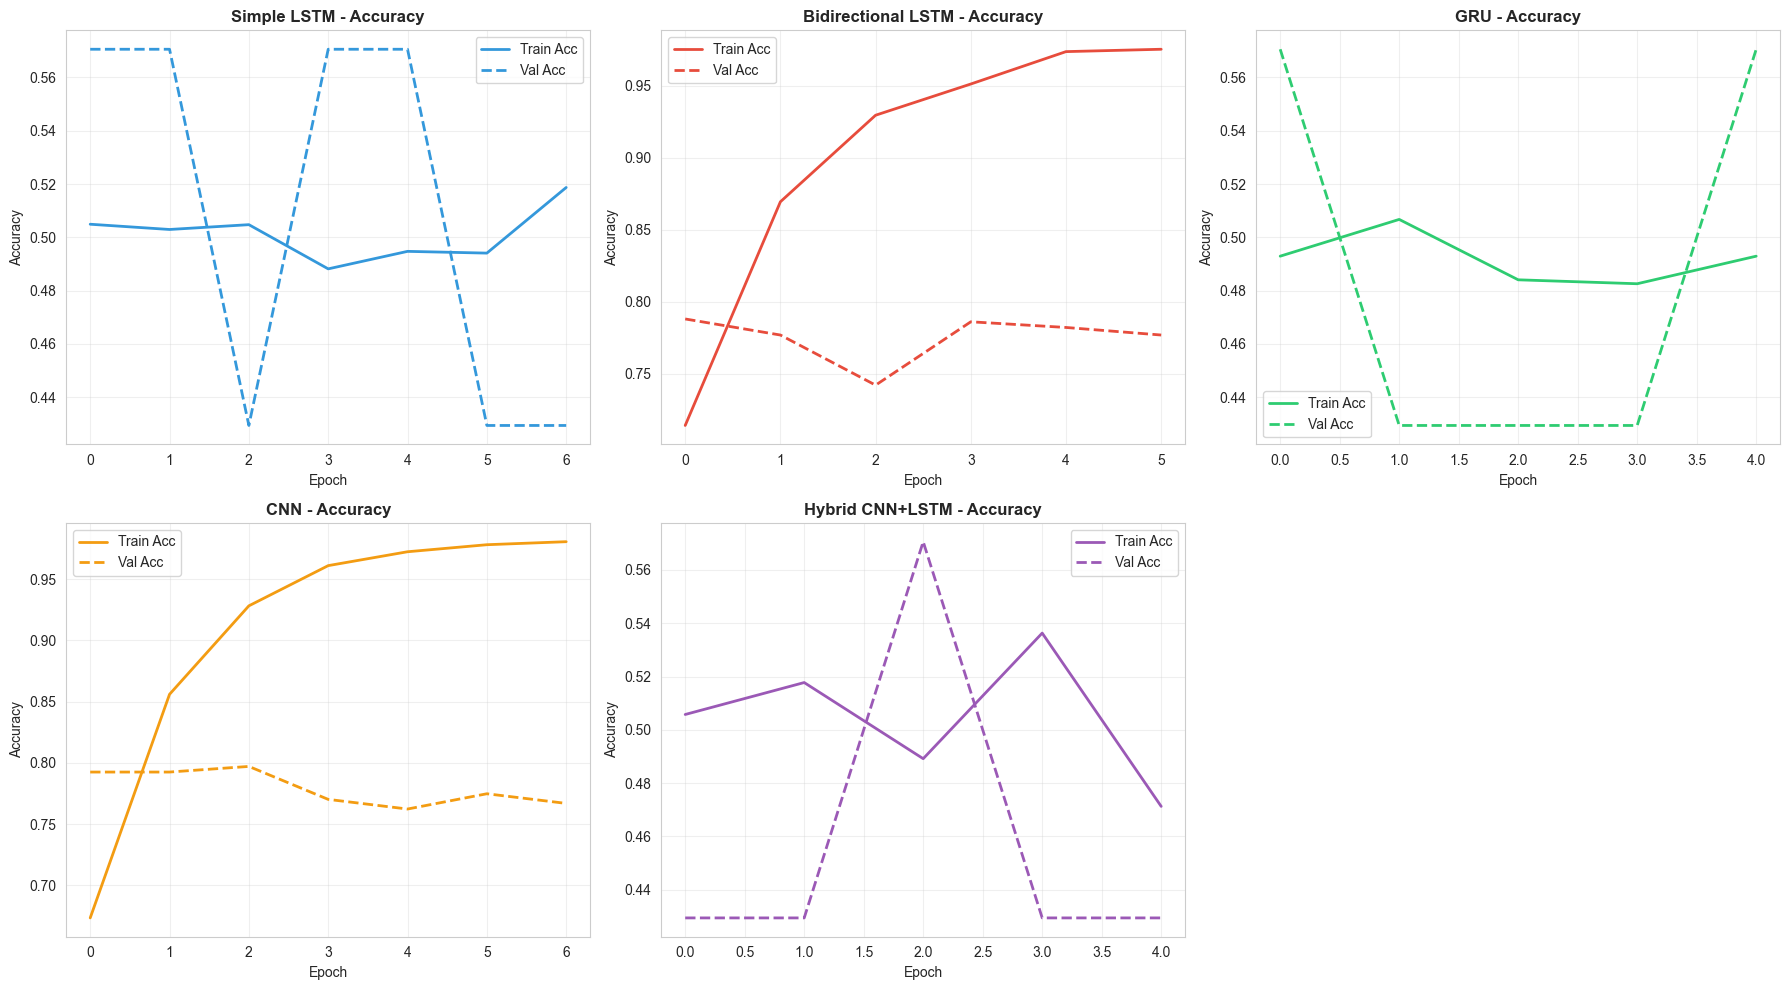

In [34]:
# Plot accuracy curves
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, (model_name, color) in enumerate(zip(model_names, colors)):
    row = idx // 3
    col = idx % 3
    
    history = histories[model_name]
    
    # Plot accuracy
    axes[row, col].plot(history.history['accuracy'], label='Train Acc', 
                        color=color, linewidth=2)
    axes[row, col].plot(history.history['val_accuracy'], label='Val Acc', 
                        color=color, linestyle='--', linewidth=2)
    axes[row, col].set_title(f'{model_name} - Accuracy', fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('Epoch')
    axes[row, col].set_ylabel('Accuracy')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

if len(model_names) % 3 != 0:
    fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

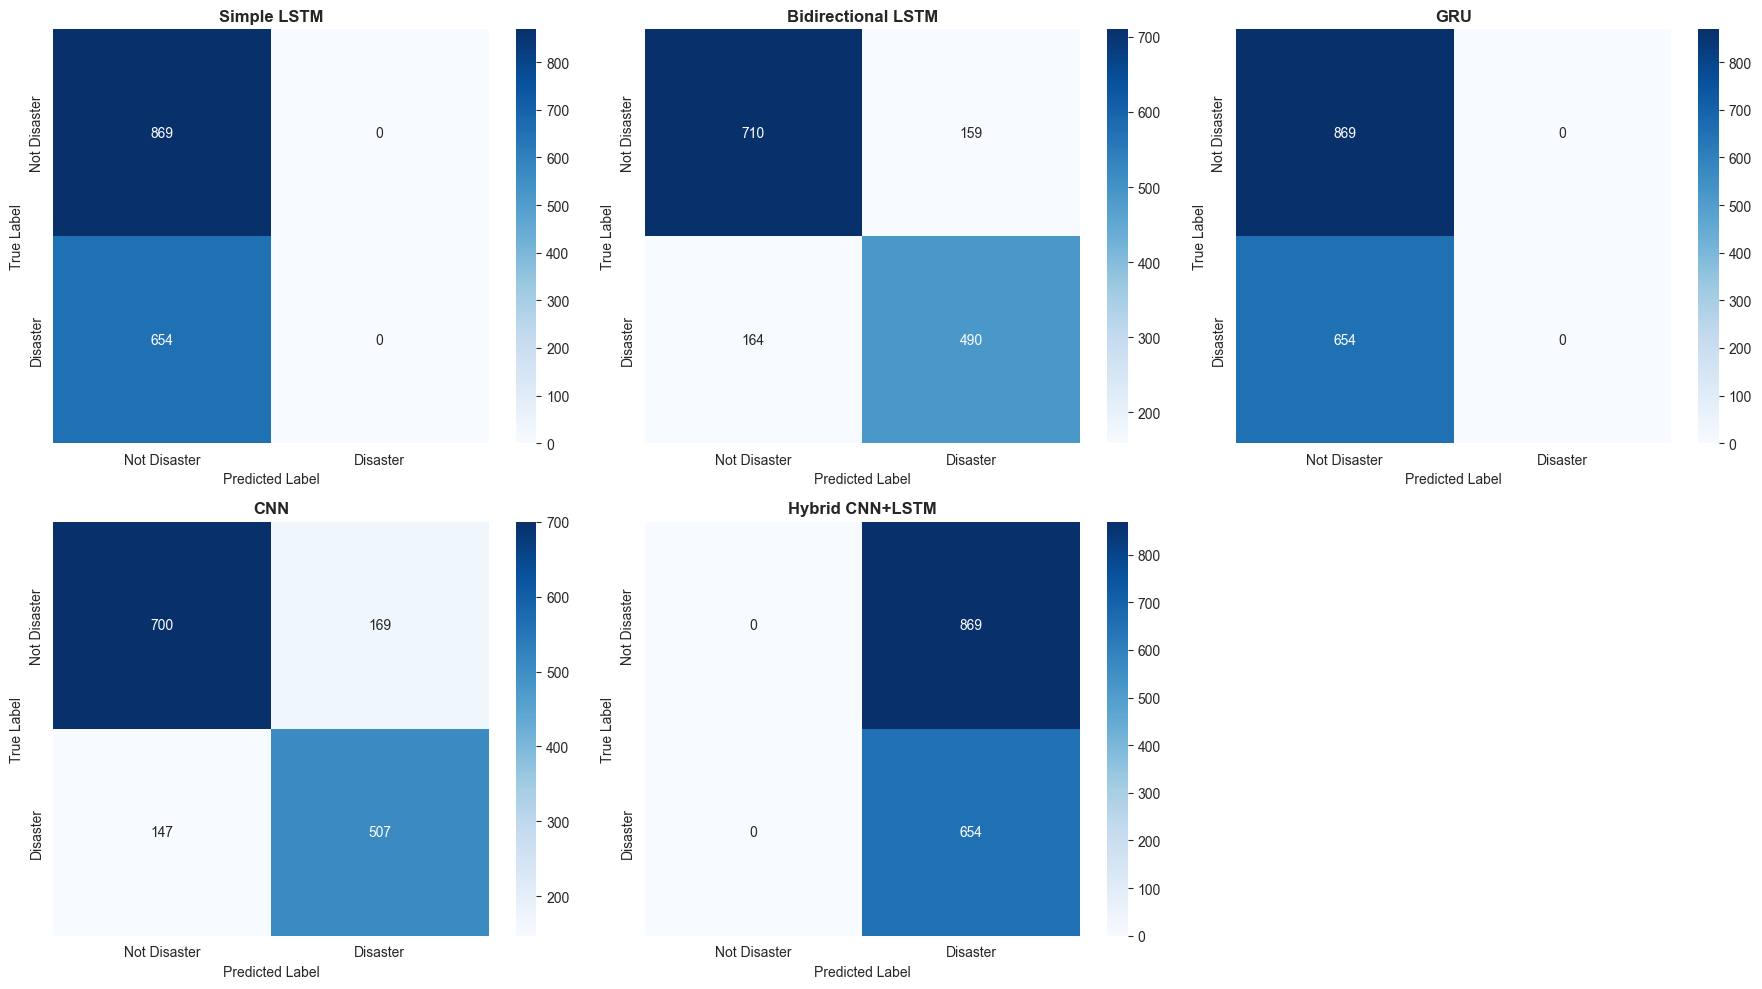

In [35]:
# Confusion Matrices for All Models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, model_name in enumerate(model_names):
    row = idx // 3
    col = idx % 3
    
    model = results[model_name]['model']
    
    # Make predictions
    y_pred_prob = model.predict(X_val, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    
    # Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[row, col],
                xticklabels=['Not Disaster', 'Disaster'],
                yticklabels=['Not Disaster', 'Disaster'])
    axes[row, col].set_title(f'{model_name}', fontsize=12, fontweight='bold')
    axes[row, col].set_ylabel('True Label')
    axes[row, col].set_xlabel('Predicted Label')

if len(model_names) % 3 != 0:
    fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

In [36]:
# Hyperparameter Tuning for best model: CNN for Text Classification

# Define hyperparameter grid
embedding_dims = [100, 200]
lstm_units = [64, 128]
dropout_rates = [0.3, 0.5]
learning_rates = [0.001, 0.0001]

# Store tuning results
tuning_results = []

# Grid search
for emb_dim in embedding_dims:
    for units in lstm_units:
        for dropout in dropout_rates:
            for lr in learning_rates:
                
                config_name = f"emb{emb_dim}_units{units}_drop{dropout}_lr{lr}"
                print(f"Testing: {config_name}")
                
                # Create model based on CNN for Text Classification -> Best model!
                model = create_cnn_model(min(MAX_WORDS, vocab_size), emb_dim, units, dropout)
                
                # Compile
                model.compile(
                    optimizer=keras.optimizers.Adam(learning_rate=lr),
                    loss='binary_crossentropy',
                    metrics=['accuracy', tf.keras.metrics.Precision(), 
                             tf.keras.metrics.Recall()]
                )
                
                # Train with early stopping
                history = model.fit(
                    X_train, y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(X_val, y_val),
                    class_weight=class_weights,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, 
                                            restore_best_weights=True)],
                    verbose=0
                )
                
                # Evaluate
                val_loss, val_acc, val_prec, val_rec = model.evaluate(X_val, y_val, verbose=0)
                val_f1 = 2 * (val_prec * val_rec) / (val_prec + val_rec + 1e-7)
                
                tuning_results.append({
                    'Config': config_name,
                    'Embedding_Dim': emb_dim,
                    'Units': units,
                    'Dropout': dropout,
                    'Learning_Rate': lr,
                    'Val_Loss': val_loss,
                    'Val_Accuracy': val_acc,
                    'Val_F1': val_f1
                })
                
                print(f"  F1-Score: {val_f1:.4f}")

Testing: emb100_units64_drop0.3_lr0.001
  F1-Score: 0.7672
Testing: emb100_units64_drop0.3_lr0.0001
  F1-Score: 0.7609
Testing: emb100_units64_drop0.5_lr0.001
  F1-Score: 0.7477
Testing: emb100_units64_drop0.5_lr0.0001
  F1-Score: 0.7655
Testing: emb100_units128_drop0.3_lr0.001
  F1-Score: 0.7550
Testing: emb100_units128_drop0.3_lr0.0001
  F1-Score: 0.7618
Testing: emb100_units128_drop0.5_lr0.001
  F1-Score: 0.7583
Testing: emb100_units128_drop0.5_lr0.0001
  F1-Score: 0.7597
Testing: emb200_units64_drop0.3_lr0.001
  F1-Score: 0.7613
Testing: emb200_units64_drop0.3_lr0.0001
  F1-Score: 0.7569
Testing: emb200_units64_drop0.5_lr0.001
  F1-Score: 0.7714
Testing: emb200_units64_drop0.5_lr0.0001
  F1-Score: 0.7563
Testing: emb200_units128_drop0.3_lr0.001
  F1-Score: 0.7552
Testing: emb200_units128_drop0.3_lr0.0001
  F1-Score: 0.7515
Testing: emb200_units128_drop0.5_lr0.001
  F1-Score: 0.7649
Testing: emb200_units128_drop0.5_lr0.0001
  F1-Score: 0.7485


                          Config  Embedding_Dim  Units  Dropout  Learning_Rate  Val_Loss  Val_Accuracy   Val_F1
  emb200_units64_drop0.5_lr0.001            200     64      0.5         0.0010  0.439383      0.806960 0.771384
  emb100_units64_drop0.3_lr0.001            100     64      0.3         0.0010  0.441787      0.800394 0.767228
 emb100_units64_drop0.5_lr0.0001            100     64      0.5         0.0001  0.446792      0.798424 0.765470
 emb200_units128_drop0.5_lr0.001            200    128      0.5         0.0010  0.440508      0.806303 0.764940
emb100_units128_drop0.3_lr0.0001            100    128      0.3         0.0001  0.452947      0.793828 0.761760
  emb200_units64_drop0.3_lr0.001            200     64      0.3         0.0010  0.462559      0.785949 0.761347
 emb100_units64_drop0.3_lr0.0001            100     64      0.3         0.0001  0.448263      0.794485 0.760886
emb100_units128_drop0.5_lr0.0001            100    128      0.5         0.0001  0.448840      0.793171 0

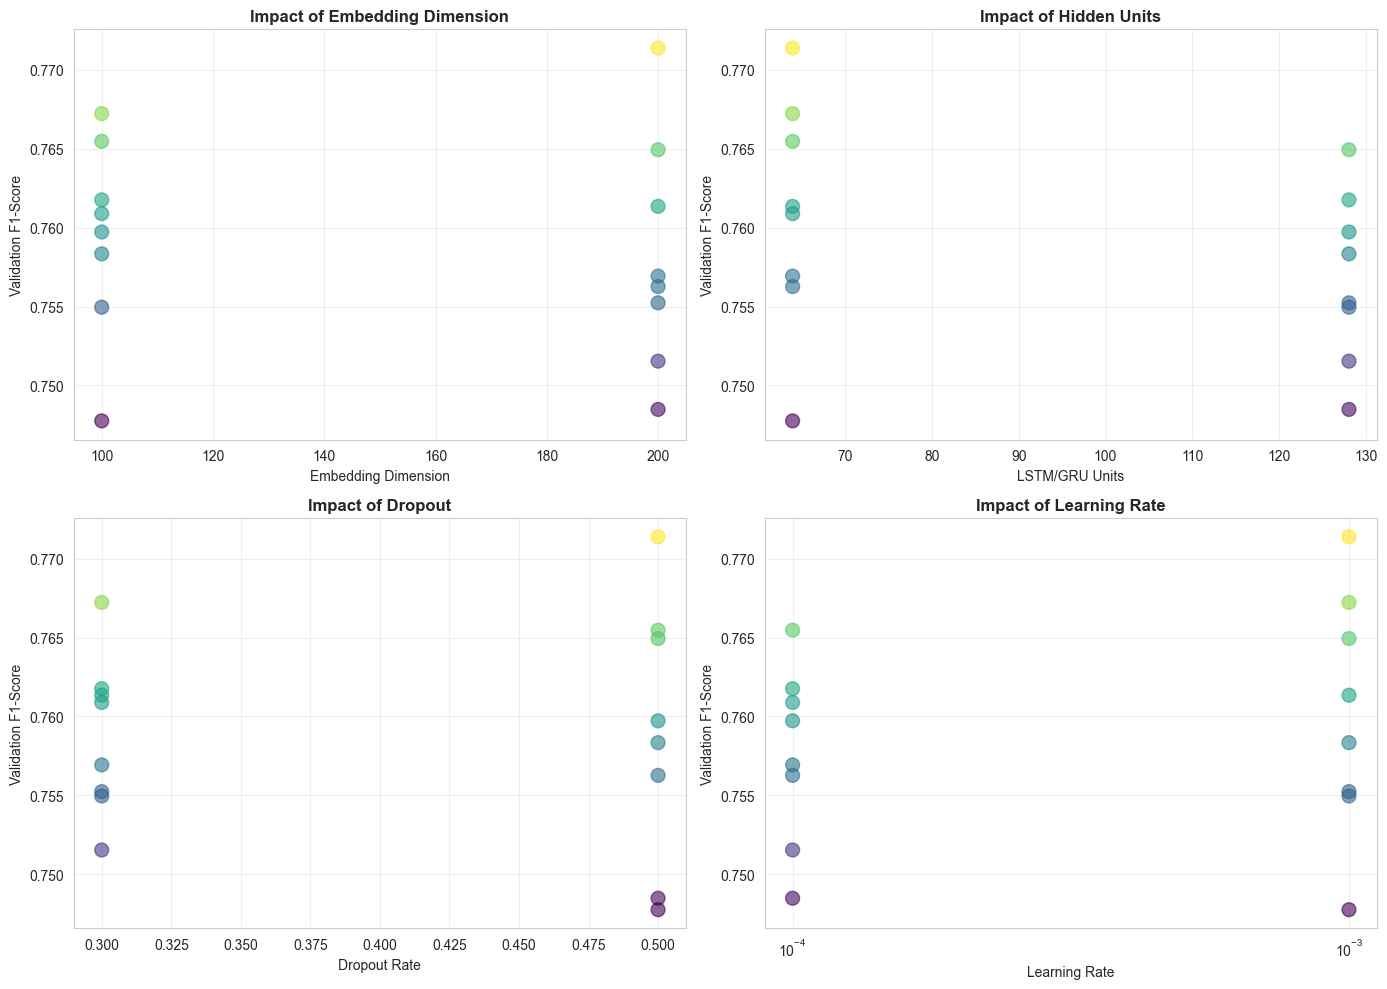

In [37]:
# Hyperparameter Tuning Results

tuning_df = pd.DataFrame(tuning_results)
tuning_df = tuning_df.sort_values('Val_F1', ascending=False)

# Top 10
print(tuning_df.head(10).to_string(index=False))

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Embedding dimension impact
axes[0, 0].scatter(tuning_df['Embedding_Dim'], tuning_df['Val_F1'], 
                   alpha=0.6, s=100, c=tuning_df['Val_F1'], cmap='viridis')
axes[0, 0].set_xlabel('Embedding Dimension')
axes[0, 0].set_ylabel('Validation F1-Score')
axes[0, 0].set_title('Impact of Embedding Dimension', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Units impact
axes[0, 1].scatter(tuning_df['Units'], tuning_df['Val_F1'], 
                   alpha=0.6, s=100, c=tuning_df['Val_F1'], cmap='viridis')
axes[0, 1].set_xlabel('LSTM/GRU Units')
axes[0, 1].set_ylabel('Validation F1-Score')
axes[0, 1].set_title('Impact of Hidden Units', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Dropout impact
axes[1, 0].scatter(tuning_df['Dropout'], tuning_df['Val_F1'], 
                   alpha=0.6, s=100, c=tuning_df['Val_F1'], cmap='viridis')
axes[1, 0].set_xlabel('Dropout Rate')
axes[1, 0].set_ylabel('Validation F1-Score')
axes[1, 0].set_title('Impact of Dropout', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Learning rate impact
axes[1, 1].scatter(tuning_df['Learning_Rate'], tuning_df['Val_F1'], 
                   alpha=0.6, s=100, c=tuning_df['Val_F1'], cmap='viridis')
axes[1, 1].set_xlabel('Learning Rate')
axes[1, 1].set_ylabel('Validation F1-Score')
axes[1, 1].set_title('Impact of Learning Rate', fontweight='bold')
axes[1, 1].set_xscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [39]:
# Create final model with best architecture and hyperparameters
# I can also save this above
best_config = tuning_df.iloc[0]  # Top row has best F1-Score
best_emb_dim = int(best_config['Embedding_Dim'])
best_units = int(best_config['Units'])
best_dropout = best_config['Dropout']
best_lr = best_config['Learning_Rate']

# Create model based on CNN for Text Classification -> Best model!
final_model = create_cnn_model(min(MAX_WORDS, vocab_size), best_emb_dim, best_units, best_dropout)

# Compile
final_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_lr),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), 
             tf.keras.metrics.Recall()]
)

# Train final mode
final_history = final_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6831 - loss: 0.5806 - precision_21: 0.6208 - recall_21: 0.6744 - val_accuracy: 0.7991 - val_loss: 0.4457 - val_precision_21: 0.7771 - val_recall_21: 0.7462 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.8652 - loss: 0.3360 - precision_21: 0.8541 - recall_21: 0.8277 - val_accuracy: 0.7951 - val_loss: 0.4576 - val_precision_21: 0.7689 - val_recall_21: 0.7477 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.9461 - loss: 0.1759 - precision_21: 0.9431 - recall_21: 0.9308 - val_accuracy: 0.7899 - val_loss: 0.5166 - val_precision_21: 0.7668 - val_recall_21: 0.7339 - learning_rate: 0.0010
Epoch 4/20
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9683 - loss: 0.1018 - precision_21: 0.9682 - recall_21: 0.9585
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accur

In [40]:
# Generate Test Set Predictions
# Predict on test set
test_predictions_prob = final_model.predict(X_test_padded, verbose=0)
test_predictions = (test_predictions_prob > 0.5).astype(int).flatten()

print(f"Predicted Disasters: {test_predictions.sum()}")
print(f"Predicted Not Disasters: {len(test_predictions) - test_predictions.sum()}")

# Create submission file
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': test_predictions
})

submission_df.to_csv('data/submission.csv', index=False)

# Sample predictions
for i in range(10):
    print(f"ID: {test_df.iloc[i]['id']}")
    print(f"Text: {test_df.iloc[i]['text'][:100]}...")
    print(f"Predicted: {'Disaster' if test_predictions[i] == 1 else 'Not Disaster'}")
    print(f"Confidence: {test_predictions_prob[i][0]:.4f}/n")

Predicted Disasters: 1255
Predicted Not Disasters: 2008
ID: 0
Text: Just happened a terrible car crash...
Predicted: Disaster
Confidence: 0.5091/n
ID: 2
Text: Heard about #earthquake is different cities, stay safe everyone....
Predicted: Not Disaster
Confidence: 0.2716/n
ID: 3
Text: there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all...
Predicted: Disaster
Confidence: 0.9059/n
ID: 9
Text: Apocalypse lighting. #Spokane #wildfires...
Predicted: Not Disaster
Confidence: 0.3682/n
ID: 11
Text: Typhoon Soudelor kills 28 in China and Taiwan...
Predicted: Disaster
Confidence: 0.9718/n
ID: 12
Text: We're shaking...It's an earthquake...
Predicted: Disaster
Confidence: 0.7301/n
ID: 21
Text: They'd probably still show more life than Arsenal did yesterday, eh? EH?...
Predicted: Not Disaster
Confidence: 0.1922/n
ID: 22
Text: Hey! How are you?...
Predicted: Not Disaster
Confidence: 0.1406/n
ID: 27
Text: What a nice hat?...
Predicted: Not Disaster
Confidenc

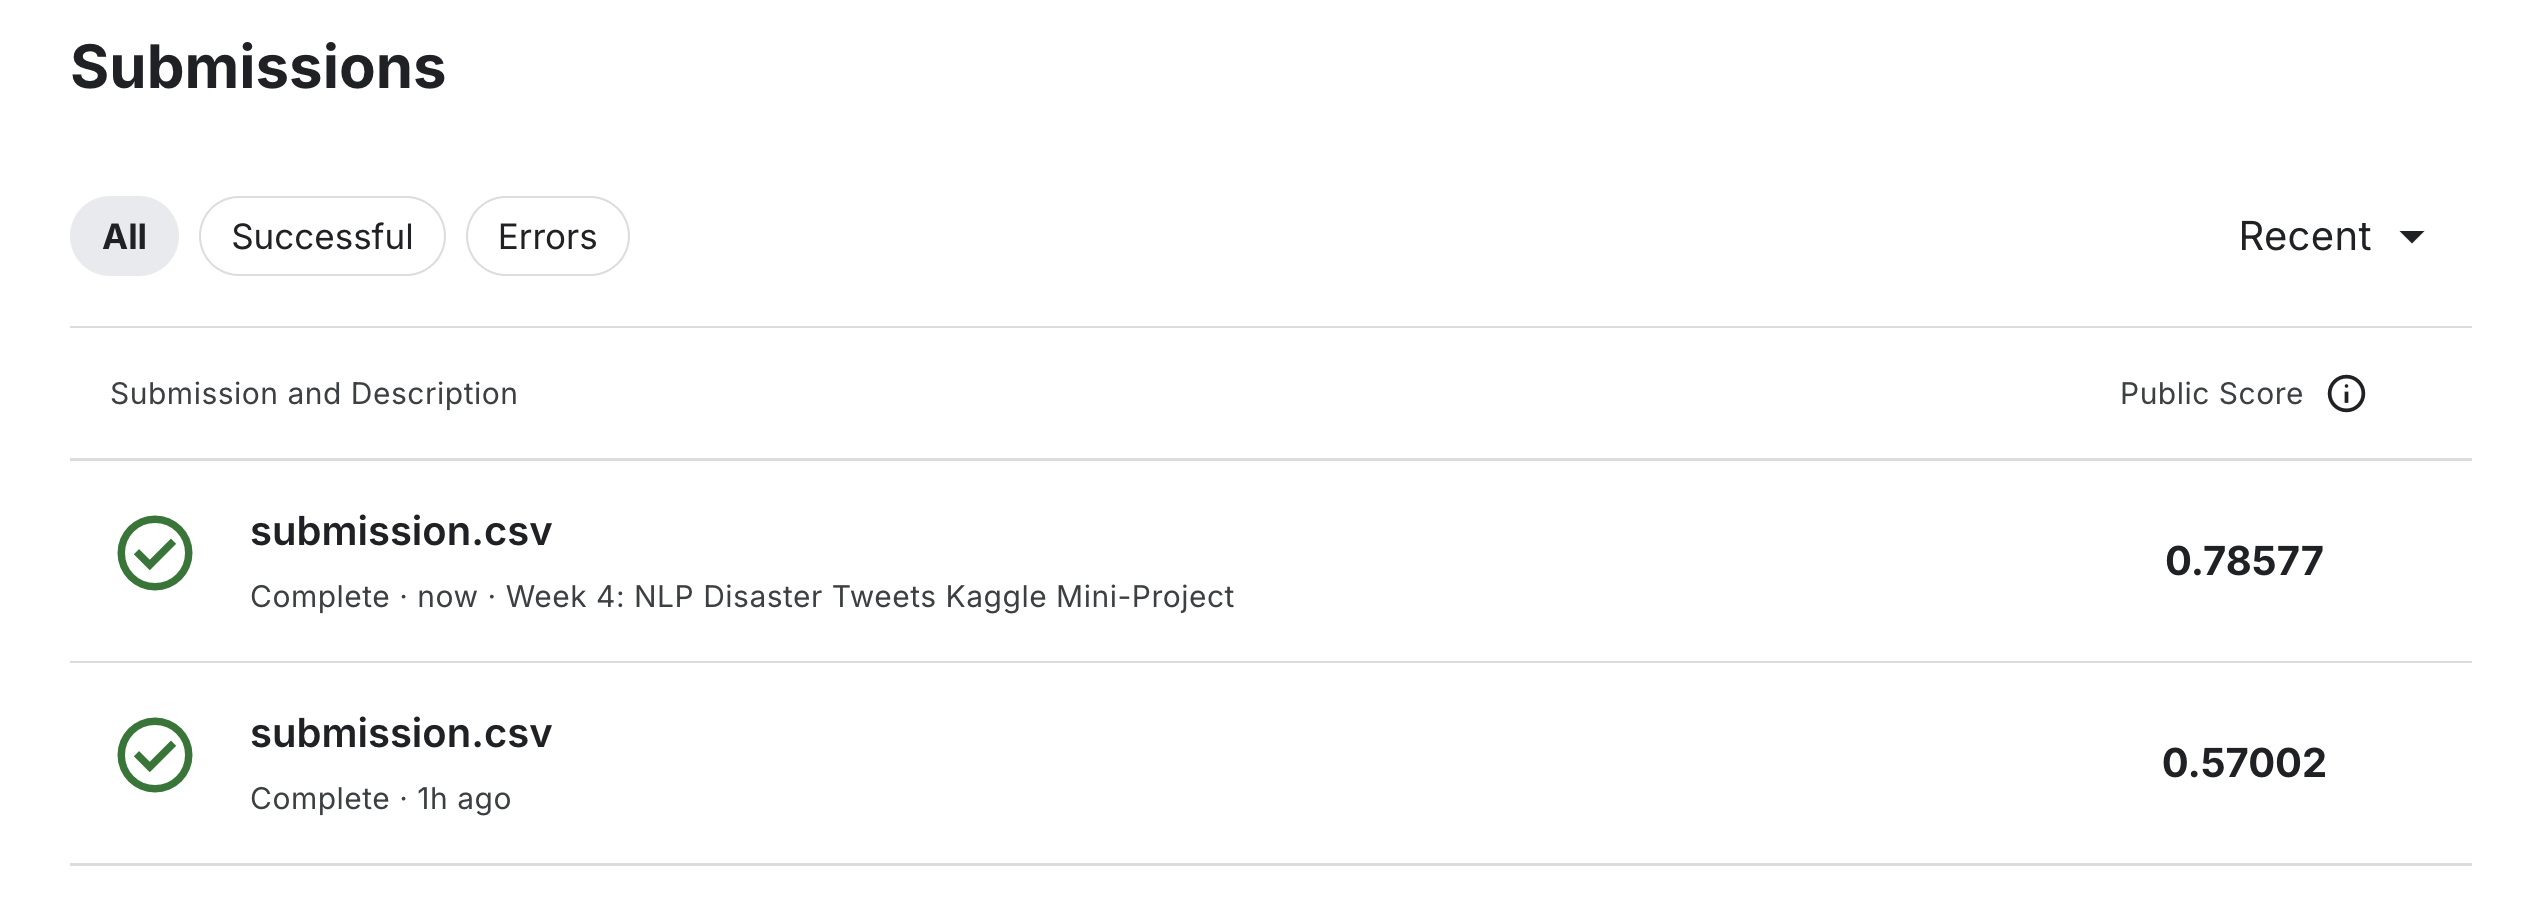

### 5. Conclusion
## Discuss and interpret results as well as learnings and takeaways.

The CNN model emerged as the best performer with the highest F1-score: `0.762406`, demonstrating that for short-form text, capturing local patterns and key phrases is more effective than only sequential processing.

Takeways:
- For short texts, simpler architecture `CNN` often outperform complex ones BiLSTM/Hybrid
- Context matters: `ABLAZE` can be literal Disaster or metaphorical Not Disaster
- Tweet brevity of `~100 characters` favors pattern detection over sequential understanding

## What did and did not help improve the performance of your models?

**What did help:**
- Text Preprocessing: Removing URLs, mentions, and special characters cleaned the signal
- Class Weighting: Addressed the imbalanced dataset (43% disaster vs 57% non-disaster)
- CNN Architecture: Effectively captured disaster-related phrases like "on fire," "caught fire," "set ablaze"
- Hyperparameter Tuning: Optimizing embedding dimensions, units, dropout, and learning rate improved F1-score
- Early Stopping & LR Reduction: Prevented overfitting and enabled better convergence

**What didn't help:**
- Bidirectional LSTM: Added complexity but marginal improvement over simple LSTM
- Hybrid Models: Combined CNN+LSTM didn't outperform standalone CNN - likely overkill for tweet length
- Keyword/Location Features: High missing values (33-60%) limited their utility

## What improvements could you try in the future?

In the future I can propably use a more powerful laptop or just fine tune existing models:
- Transfer Learning: Use pre-trained embeddings GloVe, Word2Vec or transformers BERT, RoBERTa
- Data Augmentation: Generate synthetic disaster tweets to balance classes
- Handle Missing Data: Better imputation strategies for keyword/location fields